# HW4 Oliver Li

In [ ]:
## Problem 1 - Recent Posts

<change you made>

CREATE INDEX post_timestamp_idx ON posts(post_timestamp);
SELECT
  post_id,
  post_timestamp

FROM
  posts

ORDER BY
  post_timestamp DESC

LIMIT 10

<screenshot of EXPLAIN ANALYZE>

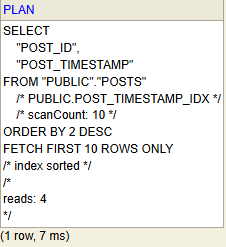

Adding an index to improve performance

In [ ]:
## Problem 2 - Somewhat Strange Query

<change you made>
ALTER TABLE posts
    ADD COLUMN author_substr VARCHAR(3) AS SUBSTR(author, 3, 3);

ALTER TABLE posts
    ADD COLUMN content_upper VARCHAR(255) AS UPPER(content);

CREATE INDEX content_idx ON posts (content);
CREATE INDEX post_timestamp_idx ON posts (post_timestamp);
CREATE INDEX author_substr_idx ON posts (author_substr);
CREATE INDEX content_upper_idx ON posts (content_upper);
SELECT
    post_id,
    post_timestamp
FROM
    posts
WHERE
    post_timestamp < '2024-02-01'
    AND content_upper LIKE 'C%'
    AND author_substr = 'son';

<screenshot of EXPLAIN ANALYZE>

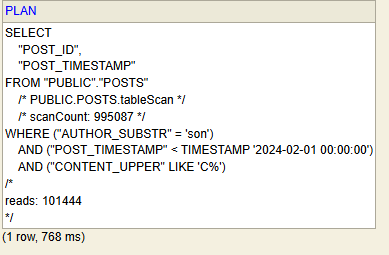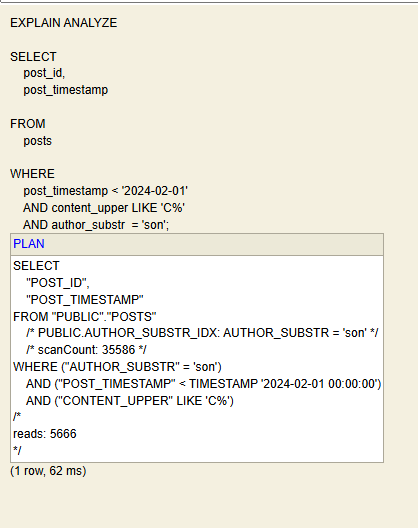

Creating an index on all the provided queries allows faster performance speed. Also creating subrows to provide the indices.

## Problem 3 - Really Fast Single Row Responses
### Problem 3.1

<What index does H2DB end up using?  Explain the pros and cons of each index that you created.>
The H2DB ends up using the B-Tree indexing.
For both of the indices:
B-Trees work fast on range queries and sorting, perform well (O(logN)) in lookup tasks/exact match queries, and more general to use.
However B-Trees take up more space and memory in practice, also performs slower in insets and updates due to re-balancing in data.
On the other hand Hash Indices use less space and performs fastest on lookup time. However it is neither useful for range queries or sorting queries.


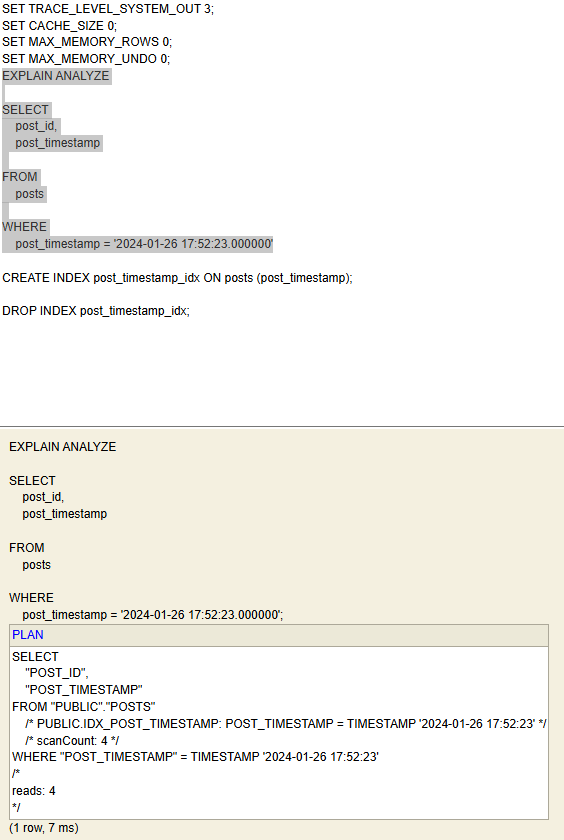

### Problem 3.2

<Which of the indexes that you created for 3.1 would you expect to be used now.  Please explain.>
It is expected to use a B-Tree Index. A BETWEEN AND operation is not supported by a hash index, as hash indices do not have order.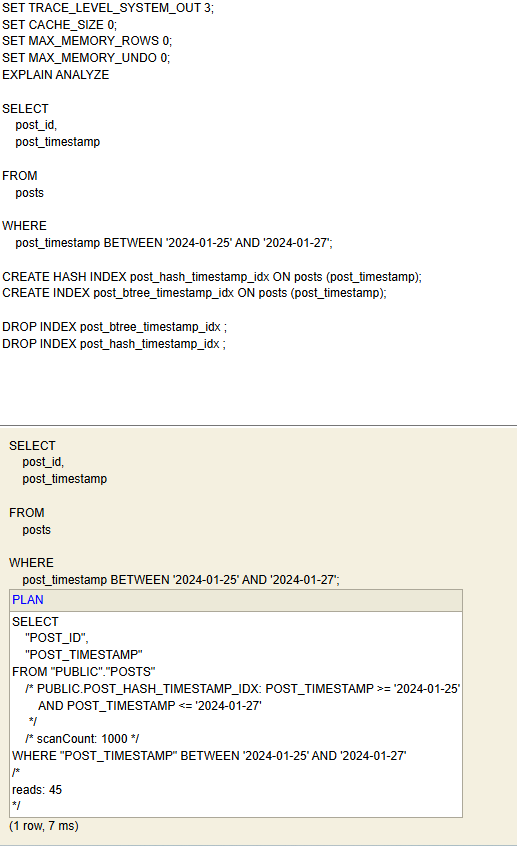

### Problem 3.3

<Can you modify one of the indexes from 3.2 to make this query even faster?  Explain why your change to the index made the query even faster.>
CREATE INDEX post_timestamp_btree_idx ON posts (post_timestamp, post_id, content);
This is a composite index that allow he coverage of all the columns in the query, where the database can fetch data directly from the index
without having to access the full table.

In [ ]:
## Problem 4 - Table Join Order
### Problem 4.1

<Your modified query here>

SELECT
   COUNT(1)

FROM
    users
    JOIN followers ON users.handle = followers.follower_handle
    JOIN posts ON followers.following_handle = posts.author

WHERE
    users.last_name = 'Anderson'
    AND users.first_name = 'Abigail';

### Problem 4.2

<List each of the four possible join orders and explain why or why not that particular join order will perform well or poorly.>
We have 3 tables to join hence we have 3!-2=4 possible joins possible, and known that the size of each table is:
    users = 10000;    followers = 995040;     posts = 995086;
 Note that the performance can only be optimized when each operation eliminates most elements first, hence given possible joins:

In [ ]:
FROM
    posts
    JOIN followers ON posts.author = followers.following_handle
    JOIN users ON followers.follower_handle = users.handle
### Gives 205 in 103754 ms
### Likely to take the longest time as the operations take the longest table first, then the second longest and the shortest.
### Elimination of rows is minimized.

FROM
    users
    JOIN followers ON users.handle = followers.follower_handle
    JOIN posts ON followers.following_handle = posts.author
### Gives 205 in 10 ms
### Likely to take the shortest time as the operations take the shortest table first, then the second shortest and the longest.
### Elimination of rows is maximized as the table is short in the first place.

FROM
    followers
    JOIN posts ON followers.following_handle = posts.author
    JOIN users ON followers.follower_handle = users.handle
### Gives 205 in 61401 ms
### Better than the first JOIN order, as the second longest table is given at first, then the longest and the shortest
### Elimination of rows is not maximized.

FROM
    followers
    JOIN users ON followers.follower_handle = users.handle
    JOIN posts ON followers.following_handle = posts.author
### Gives 205 in 672 ms
### Better than the previous JOIN order, as the second longest table is given at first, then the shortest and the longest
### Elimination of rows is not maximized but slightly better than the previous operation order, as 995040->10000 is better than 995040->995086.

In [ ]:
## Problem 5 - Putting it All Together - Fast Most Recent Posts

<your query here>
DROP INDEX IF EXISTS posts_author_idx;
DROP INDEX IF EXISTS followers_follower_idx;
DROP INDEX IF EXISTS followers_following_idx;
DROP INDEX IF EXISTS posts_timestamp_idx;

CREATE HASH INDEX followers_following_idx ON followers (following_handle);
CREATE HASH INDEX followers_follower_idx ON followers (follower_handle);
CREATE HASH INDEX posts_author_idx ON posts (author);

CREATE INDEX posts_timestamp_idx ON posts (post_timestamp DESC);

EXPLAIN ANALYZE
WITH latest_posts AS (
   SELECT
       p1.author,
       MAX(p1.post_timestamp) AS latest
   FROM followers f
   JOIN posts p1
       ON p1.author = f.following_handle
   WHERE f.follower_handle = 'madison.anderson9901'
   GROUP BY p1.author
)
SELECT
    p2.author,
    p2.post_id,
    p2.post_timestamp,
    p2.content
FROM latest_posts sub
JOIN posts p2
    ON p2.author = sub.author
    AND p2.post_timestamp = sub.latest
ORDER BY p2.post_timestamp DESC;


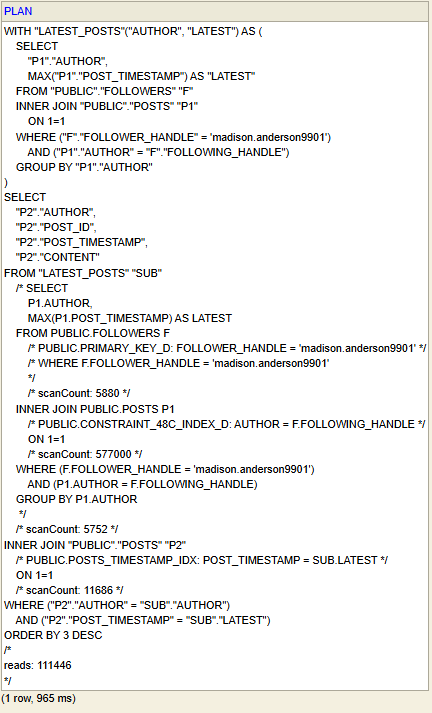